# Bayesian models of Tully-Fisher extragalactic distance errors in NED-D

Companion notebook for the "Predicting extragalactic distance errors using bayesian inference in multi measurement catalogues" paper, Monthly Notices of the Royal Astronomical Society, Volume 485, Issue 3, May 2019, Pages 4343–4358, https://doi.org/10.1093/mnras/stz615

This notebook shows:

- A comparison between our proposed robust bootstrap distance and distance errors (H,M) and frequentist distance errors (P,Q), pre-computed in the [previous notebook](computing_errors.ipynb)
- Bayesian regression models (linear and quadratic) for estimating extragalactic distance errors (H,M) from each extragalactic distance.
- Model checking for those regression models using a discrepancy measure and a Bayesian "p-value"

The following notebook is [here](prediction_errors.ipynb).

In [ ]:
%%bash
# Here we download the pre-computed Tully-Fisher Relation errors 
wget https://github.com/saint-germain/anisotropias/raw/master/bootstrap_results_2018.csv
wget https://github.com/saint-germain/anisotropias/raw/master/bootstrap_results_wm_2018.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op
import emcee
import corner
%matplotlib inline
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
sns.set()
sns.set_style("whitegrid")
current_palette = sns.color_palette()
from matplotlib.pyplot import cm

In [2]:
#Here we read the results from the pre-computed distance and distance errors
ndf=pd.read_csv("bootstrap_results_2018.csv")
bdf=pd.read_csv("bootstrap_results_wm_2018.csv")

em=ndf.meas # number of measurements

# Bootstrap (bootstrap-sampled distance posterior distribution) quantities:
dboot=ndf.dboot # bootstrap median distance (Mpc)
bootp50=ndf.bootp50 # H error (half of bootstrap 84th-16th distance percentile) (Mpc)
bootmad=ndf.bootmad # M error (Median Absolute Deviation of bootstrap) (Mpc)
bootsig=ndf.bootsig # variance of H error (Mpc)
bootmsig=bdf.bootmsig # variance of M error (Mpc)

# Frequentist quantities:
dwa=ndf.dwa # weighted mean distance (Mpc)
wsnt=ndf.wsnt # weighted standard deviation
ecf=ndf.ecf # P error (cosmicflows/propagated error) (Mpc)
eqd=ndf.eqd # Q error (quadrature sum of weighted standard deviation and P error) (Mpc)

(-5, 120)

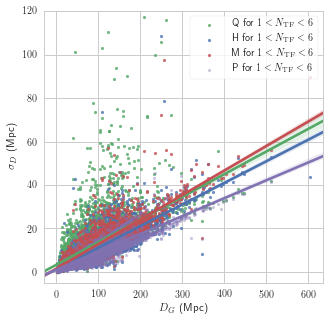

In [3]:
# Here we filter all relevant quantities by number of measurements (for plotting how distance errors vary with distance)
ulim=6
filt=(np.array(em)<ulim)
x=np.array(dboot)[filt]
xa=np.array(dwa)[filt]
y=np.array(bootp50)[filt]
w=np.array(wsnt)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]
ms=np.array(bootmsig)[filt]
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1], scatter_kws={'alpha':0.8,'s':10},label='Q for $1<N_\mathrm{TF}<%i$'%ulim) # green, quadrature
sns.regplot(x,y,color=current_palette[0],label=r'H for $1<N_\mathrm{TF}<%i$'%ulim, scatter_kws={'s':10})
sns.regplot(x,z,color=current_palette[2],label='M for $1<N_\mathrm{TF}<%i$'%ulim, scatter_kws={'alpha':0.8,'s':10})
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.4,'s':10},label='P for $1<N_\mathrm{TF}<%i$'%ulim) # red, cosmicflows
plt.legend(loc='upper right',frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.ylim(-5,120)

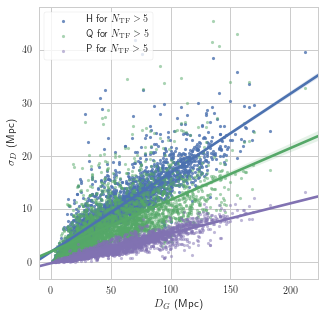

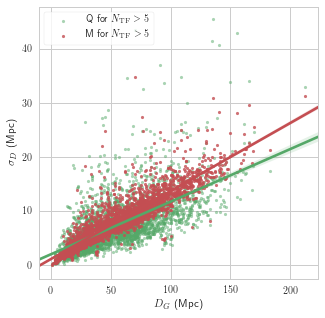

In [4]:
# Here we filter all relevant quantities by number of measurements (for plotting how distance errors vary with distance)
llim=5
filt=np.array(em)>llim
x=np.array(dboot)[filt]
xa=np.array(dwa)[filt]
y=np.array(bootp50)[filt]
w=np.array(wsnt)[filt]
cf=np.array(ecf)[filt]
qd=np.array(eqd)[filt]
z=np.array(bootmad)[filt]
ee=np.array(bootsig)[filt]
ms=np.array(bootmsig)[filt]
# For clarity we make two separate plots
plt.figure(figsize=(5,5))
sns.regplot(x,y,label='H for $N_\mathrm{TF}>%i$'%llim, scatter_kws={'s':10})
sns.regplot(x,qd, scatter_kws={'alpha':0.5,'s':10},label='Q for $N_\mathrm{TF}>%i$'%llim) # green, quadrature
sns.regplot(x,cf,color=current_palette[3], scatter_kws={'alpha':0.5,'s':10},label='P for $N_\mathrm{TF}>%i$'%llim) # purple, cosmicflows
plt.legend(loc='upper left',frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.show()
plt.figure(figsize=(5,5))
sns.regplot(x,qd,color=current_palette[1],label='Q for $N_\mathrm{TF}>%i$'%llim, scatter_kws={'alpha':0.5,'s':10}) 
sns.regplot(x,z,color=current_palette[2],label='M for $N_\mathrm{TF}>%i$'%llim, scatter_kws={'alpha':0.8,'s':10}) # red, MAD
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.show()

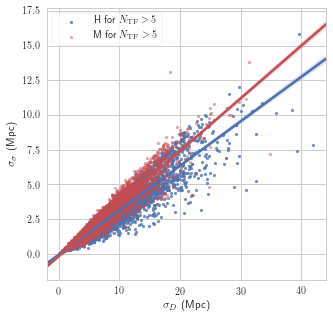

In [5]:
# This plot shows how the variance of H and M errors changes with distance
# As per the last filter, this is for galaxies with more than 5 measurements
plt.figure(figsize=(5,5))
sns.regplot(y,ee,color=current_palette[0], scatter_kws={'s':10},label='H  for $N_\mathrm{TF}>%i$'%llim) # error of the error
sns.regplot(z,ms,color=current_palette[2], scatter_kws={'alpha':0.5,'s':10},label='M for $N_\mathrm{TF}>%i$'%llim) # error of the error
plt.xlabel(r"$\sigma_D$ (Mpc)")
plt.ylabel(r'$\sigma_\sigma$ (Mpc)')
plt.legend(frameon=True)
plt.show()

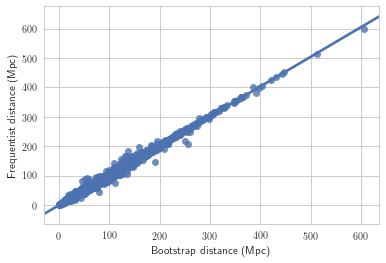

In [6]:
# This plot shows bootstrap-sampled distances vs. frequentist weighted mean distances for all galaxies in sample
sns.regplot(dboot,dwa)
plt.xlabel('Bootstrap distance (Mpc)')
plt.ylabel('Frequentist distance (Mpc)')
plt.show()

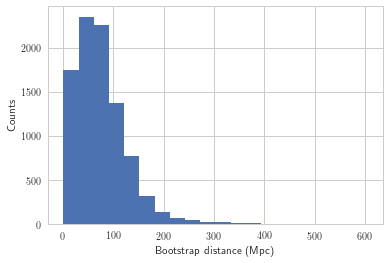

In [7]:
# This plot shows a histogram of bootstrap distances for all galaxies in sample
plt.hist(dboot,bins=20)
plt.xlabel('Bootstrap distance (Mpc)')
plt.ylabel('Counts')
plt.show()

Text(0,0.5,'$\\sigma_D$ (Mpc) - H')

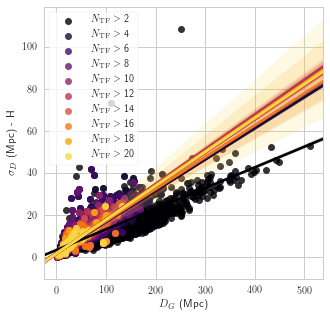

In [8]:
# this plot shows that the trend in H errors does not depend significantly on the lower limiting number of measurements
num=11
color=cm.inferno(np.linspace(0,1,num))
plt.figure(figsize=(5,5))
for i in range(2,2*num,2):
    filt=(np.array(ndf.meas[ndf.meas>1])>i)
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    sns.regplot(x,y,color=color[(i-2)//2],label='$N_\mathrm{TF}>$ '+str(i))
                #current_palette[(i-2)//2]) # green, quadrature 
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc) - H')

Text(0,0.5,'$\\sigma_D$ (Mpc) - M')

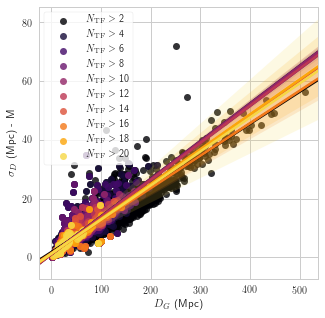

In [9]:
# this plot shows that the trend in M errors does not depend significantly on the lower limiting number of measurements
color=cm.inferno(np.linspace(0,1,11))
plt.figure(figsize=(5,5))
for i in range(2,22,2):
    filt=(np.array(ndf.meas[ndf.meas>1])>i)
    x=np.array(dboot)[filt]
    y=np.array(bootmad)[filt]
    sns.regplot(x,y,color=color[(i-2)//2],label='$N_\mathrm{TF}>$ '+str(i))
                #current_palette[(i-2)//2]) # green, quadrature 
plt.legend(loc='upper left',frameon=True)#bbox_to_anchor=(1.3, 0.5))
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc) - M')

# Bayesian Quadrature Model

$$\sigma_D=\sqrt{(mD+c)^2+b^2 }$$
$$\sigma_{SW}=f\sigma_D$$
The quadrature model includes a zero-point and a scale factor in the systematic error in addition to a random error component, added in quadrature. It shows numerical instability due to the degeneracy between the zero-point error and the random error.

One of the main results is that the favored value of $b$ is zero in the MCMC sampling, which leads to a linear model (below), which behaves much better. The following shows the reasons why the (family of) quadrature model(s) is rejected.

In [10]:
# Likelihood
def lnlike4(theta, x, y):
    # This sets the log-likelihood from a gaussian likelihood:
    # likelihood for obtaining a value for the distance error given a value for the distance
    # and given a set of parameters m,c,b,f
    m ,b,f,c = theta
    model = np.sqrt((m*x+c)**2+ b**2) # this is the quadrature model
    inv_sigma2 = 1.0/(f*model)**2 # the variance in the error also changes linearly with distance
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
# Prior
def lnprior4(theta):
    # This sets the log-prior from a uniform prior within a reasonable range for the set of parameters
    m, b, f,c = theta
    if 0 < m < 1 and -10 < b < 10 and 0 < f < 1 and 0 < c < 10:
        return 0.0
    return -np.inf
# Posterior
def lnprob4(theta, x, y):
    # This sets the log-posterior from the likelihood*prior, which will be sampled by emcee later
    lp = lnprior4(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike4(theta, x, y)
# Discrepancy
def discrep4(ii,samples,x,y):
    # This function calculates the discrepancies, makes the discrepancy plot 
    # and computes the corresponding Bayesian "p-value"
    # from ii: the lower limiting number of measurements per galaxy
    # samples: the posterior samples in the parameter space (m,c,b,f) from the emcee random walkers
    # x: extragalactic distance (pre-filtered by ii)
    # y: H/M error (pre-filtered by ii)
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100 # we only take 1 discrepancy sample for every 100 random walker sampled set of parameter points
    for i in range(ndisc):
        yexp=(samples[i,0]*x+samples[i,3])**2+samples[i,1]**2
        yexp=np.sqrt(yexp) # expected values yexp for H/M errors from the linear model  
                           # from a random parameter space point (m,c,b,f) taken from the posterior samples
        modpar=samples[np.random.randint(len(samples))] # take another random parameter space point (m,b,f) 
                                                        # from the posterior samples
        # use modpar to generate a synthetic ysim for each x using the likelihood
        ymod=(modpar[0]*x+modpar[3])**2+modpar[1]**2
        ymod=np.sqrt(ymod)
        ysim=np.random.normal(ymod,modpar[2]*ymod)
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # simulated discrepancy (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # observed discrepancy (Freeman-Tukey)
    print("Rejection rate =",100*rej//ndisc,"%") # fraction of times a negative ysim was generated wrt the number of discrepancy samples
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        # make the discrepancy plot
        plt.scatter(disco,discs,alpha=0.4,label=r"$N_\mathrm{TF}>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')
        # the Bayesian "p-value" is the fraction of discrepancy realizations 
        # when the observed discrepancy is lower than the simulated discrepancy
        # ideally this "p-value" should not be close to 0 or 1
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

## Quadrature model for H errors

The ideal model should yield that the discrepancy points are evenly distributed above and below the obs=sim line. This is also reflected in a Bayesian "p-value" close(-ish) to 0.5

Galaxies in sample:  70  for N_meas >  23
ML estimation:  0.227713516149 -4.68545964467e-07 0.251506926141 0.511225209013
MCMC estimation:  [ 0.22360396 -0.00368776  0.26065282  0.49782653]
Rejection rate = 0 %
Bayesian p-value: 0.0500076386413
Galaxies in sample:  49  for N_meas >  24
ML estimation:  0.251203412704 -7.06105515693e-07 0.258006661852 0.189906604394
MCMC estimation:  [ 0.23135352  0.0034605   0.2722766   0.43440879]
Rejection rate = 1 %
Bayesian p-value: 0.133575670694
Galaxies in sample:  31  for N_meas >  25
ML estimation:  0.25683730689 -1.9407000791e-05 0.255887323893 0.197770850693
MCMC estimation:  [ 0.22471634 -0.0107396   0.27779974  0.59528366]
Rejection rate = 1 %
Bayesian p-value: 0.68536672997


(0, 20)

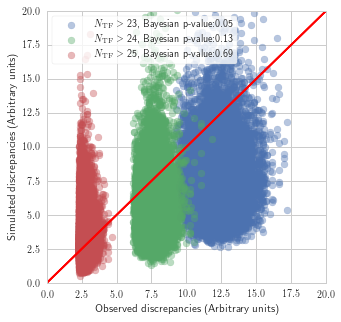

In [11]:
# Here we sample the posterior for the quadrature model and do the model check with the discrepancy function
# We increase the lower limiting number of measurements per galaxy in each model run
plt.figure(figsize=(5,5))
for i in range(23,26): # run the posterior sampler/model check for three lowest limiting number of measurements
    filt=np.array(em)>i
    print("Galaxies in sample: ",filt.sum()," for N_meas > ",i)
    xx=np.array(dboot)[filt] # median bootstrap distance
    yy=np.array(bootp50)[filt] # H distance error
    nll = lambda *args: -lnlike4(*args) # likelihood as lambda function for ML estimation
    result = op.minimize(nll, [1.]*4, args=(xx, yy)) # ML estimation for m,c,b,f
    m_ml, b_ml,f_ml,c_ml = result["x"]
    print("ML estimation: ",m_ml,b_ml,f_ml,c_ml)
    ndim, nwalkers = len(result["x"]), 100 # set up the number of MCMC random walkers
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] # set up initial positions of MCMC RW
    samplerq = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=(xx, yy))  # set up the MCMC sampler
    steps=20000     # Let the walkers walk 10000 steps (1000 will do the trick as well)
    samplerq.run_mcmc(pos, steps); # run the sampler
    # Here we remove the burn-in steps, which we estimate to be below 100
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesq = samplerq.chain[:, 200:, :].reshape((-1, ndim)) 
    sthq=samplesq.mean(axis=0) # mean MCMC estimation for m,c,b,f: should not be too different from ML estimation
    print("MCMC estimation: ",sthq)
    discrep4(i,samplesq,xx,yy) # run model check function
                               # yields discrepancy plot, rejection rate, and Bayesian "p-value"
plt.legend(loc='upper left',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(0,20)
plt.ylim(0,20)

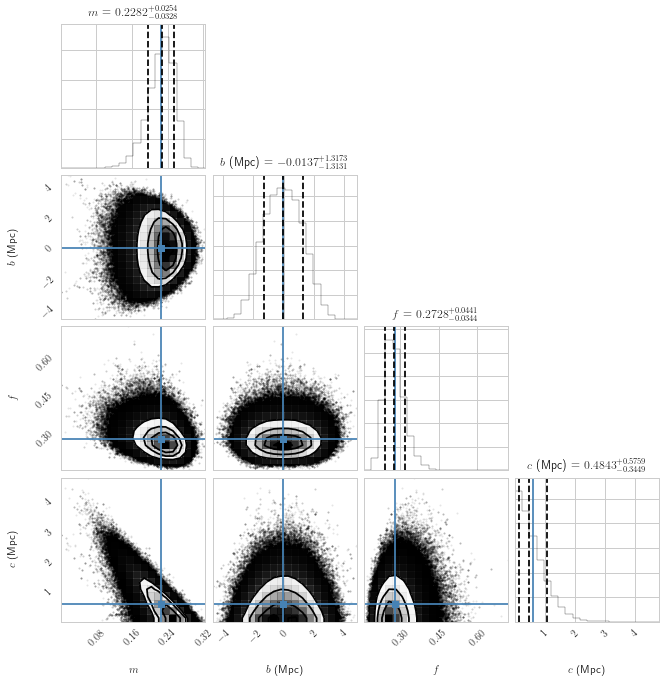

In [12]:
# corner plot for the posterior samples of the "best" model above (for H errors)
fig = corner.corner(samplesq, labels=["$m$", "$b$ (Mpc)","$f$","$c$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

(5, 40)

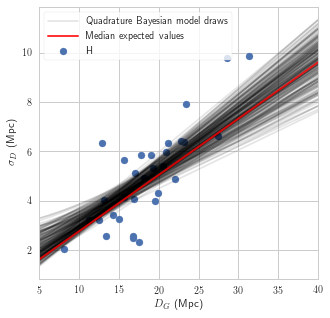

In [13]:
# Draws from the "best" model plotted along the H errors used in the model
# Projection of emcee results into the space of the observed data
plt.figure(figsize=(5,5))
plt.scatter(xx,yy,label="H")
xl = np.linspace(5,40,2000)
sthq=np.median(samplesq,axis=0)
for m, b,f,c in samplesq[np.random.randint(len(samplesq), size=200)]:
    plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1)
plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1,label="Quadrature Bayesian model draws")
plt.plot(xl, np.sqrt((sthq[0]*xl+sthq[3])**2+sthq[1]**2), color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(5,40)

Text(0,0.5,'H Error (Mpc)')

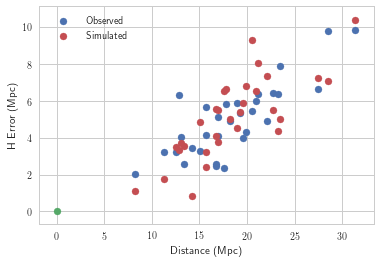

In [14]:
# Plot a set of ysim (synthetic errors produced by the model) along with the observed y (errors)
modparq=samplesq[np.random.randint(len(samplesq))]
ymod=np.sqrt((modparq[0]*xx+modparq[3])**2+modparq[1]**2)
ysim=np.random.normal(ymod,modparq[2]*ymod)
plt.scatter(xx,yy,label="Observed")
plt.scatter([0],[0])
plt.scatter(xx,ysim,label="Simulated")
plt.legend()
plt.xlabel("Distance (Mpc)")
plt.ylabel("H Error (Mpc)")

Autocorrelation time for m,c,b,f
63.3809205762 9.96112024052
86.4502324734 19.2325794526
61.0080340119 8.41094868854
66.5094760828 10.62514234


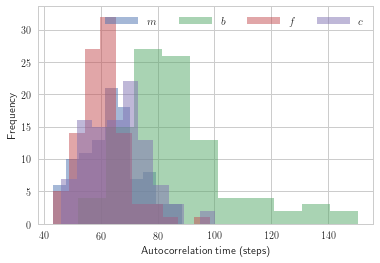

In [15]:
# Estimate autocorrelation time of the MCMC sampling for the "best" model
print("Autocorrelation time for m,c,b,f")
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(samplerq.chain[i,:,j],c=3))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ["$m$", "$b$","$f$","$c$"],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

## Quadrature model for M errors

The ideal model should yield that the discrepancy points are evenly distributed above and below the obs=sim line. This is also reflected in a Bayesian "p-value" close(-ish) to 0.5

Galaxies in sample:  926  for N_meas >  12
ML estimation:  0.141318290255 -8.24334629998e-08 0.228716029375 0.540071468545
MCMC estimation:  [ 0.14133593  0.00109196  0.22936676  0.53527054]
Rejection rate = 0 %
Bayesian p-value: 0.938450472667
Galaxies in sample:  732  for N_meas >  13
ML estimation:  0.141415244057 6.82734616837e-08 0.23115823649 0.522741858086
MCMC estimation:  [  1.41446180e-01  -4.03671812e-04   2.32023352e-01   5.15685524e-01]
Rejection rate = 0 %
Bayesian p-value: 0.607766591329


(40, 90)

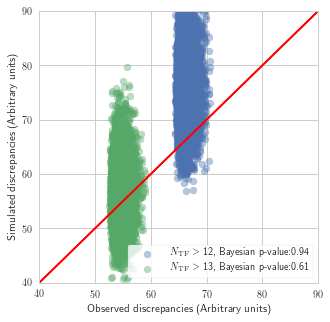

In [16]:
# Here we sample the posterior for the quadrature model and do the model check with the discrepancy function
# We increase the lower limiting number of measurements per galaxy in each model run
plt.figure(figsize=(5,5))
for i in range(12,14): # run the posterior sampler/model check for two lowest limiting number of measurements
    filt=np.array(em)>i
    print("Galaxies in sample: ",filt.sum()," for N_meas > ",i)
    xx=np.array(dboot)[filt] # median bootstrap distance
    yy=np.array(bootmad)[filt] # M distance error
    nll = lambda *args: -lnlike4(*args) # likelihood as lambda function for ML estimation
    result = op.minimize(nll, [1.]*4, args=(xx, yy)) # ML estimation for m,c,b,f
    m_ml, b_ml,f_ml,c_ml = result["x"]
    print("ML estimation: ",m_ml,b_ml,f_ml,c_ml)
    ndim, nwalkers = len(result["x"]), 100 # set up the number of MCMC random walkers
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] # set up initial positions of MCMC RW
    samplerq = emcee.EnsembleSampler(nwalkers, ndim, lnprob4, args=(xx, yy))  # set up the MCMC sampler
    steps=10000     # Let the walkers walk 10000 steps (1000 will do the trick as well)
    samplerq.run_mcmc(pos, steps); # run the sampler
    # Here we remove the burn-in steps, which we estimate to be below 100
    # This can be estimated by calculating the autocorrelation time (see below)
    samplesq = samplerq.chain[:, 200:, :].reshape((-1, ndim)) 
    sthq=samplesq.mean(axis=0) # mean MCMC estimation for m,c,b,f: should not be too different from ML estimation
    print("MCMC estimation: ",sthq)
    discrep4(i,samplesq,xx,yy) # run model check function
                               # yields discrepancy plot, rejection rate, and Bayesian "p-value"
plt.legend(loc='lower right',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(40,90)
plt.ylim(40,90)

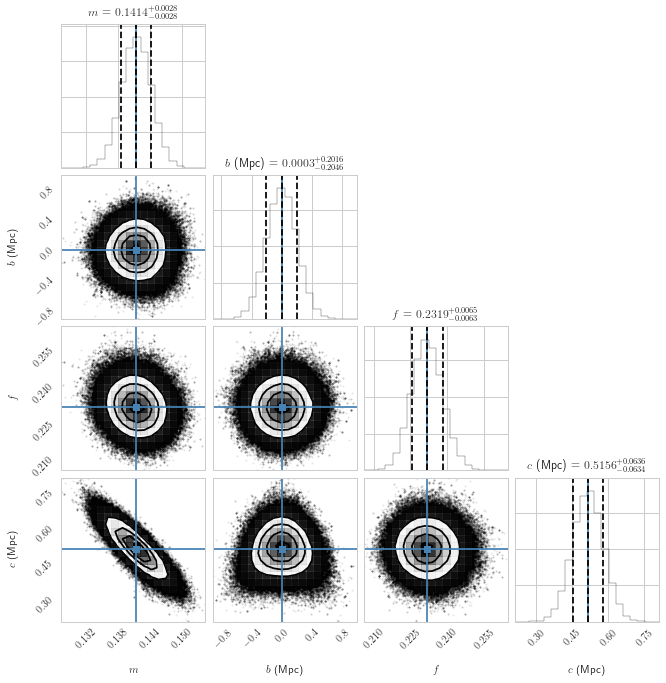

In [17]:
# corner plot for the posterior samples of the "best" model above (for H errors)
fig = corner.corner(samplesq, labels=["$m$", "$b$ (Mpc)","$f$","$c$ (Mpc)"],truths=sthq, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

(0, 25)

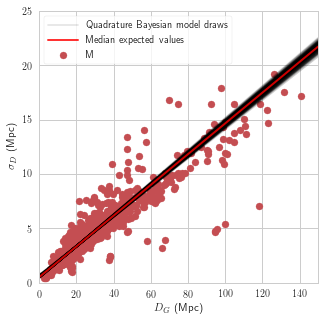

In [18]:
# Draws from the "best" model plotted along the H errors used in the model
# Projection of emcee results into the space of the observed data
plt.figure(figsize=(5,5))
plt.scatter(xx,yy,c=current_palette[2],label="M")
xl = np.linspace(0,150,200)
sthq=np.median(samplesq,axis=0)
for m, b,f,c in samplesq[np.random.randint(len(samplesq), size=200)]:
    plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1)
plt.plot(xl, np.sqrt((m*xl+c)**2+b**2), color="k", alpha=0.1,label="Quadrature Bayesian model draws")
plt.plot(xl, np.sqrt((sthq[0]*xl+sthq[3])**2+sthq[1]**2), color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,25)

Text(0,0.5,'M Error (Mpc)')

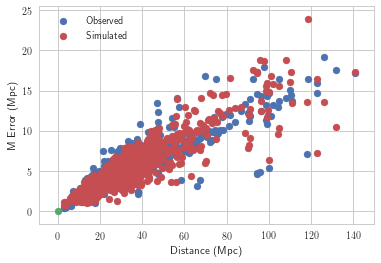

In [19]:
# Plot a set of ysim (synthetic errors produced by the model) along with the observed y (errors)
modparq=samplesq[np.random.randint(len(samplesq))]
ymod=np.sqrt((modparq[0]*xx+modparq[3])**2+modparq[1]**2)
ysim=np.random.normal(ymod,modparq[2]*ymod)
plt.scatter(xx,yy,label="Observed")
plt.scatter([0],[0])
plt.scatter(xx,ysim,label="Simulated")
plt.legend()
plt.xlabel("Distance (Mpc)")
plt.ylabel("M Error (Mpc)")

Autocorrelation time for m,c,b,f
47.7009170061 9.20844516817
50.2059633855 10.1471153285
49.0899912733 10.6381601907
47.2885030031 8.95909757472


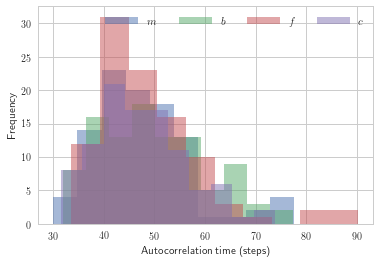

In [20]:
# Estimate autocorrelation time of the MCMC sampling for the "best" model
print("Autocorrelation time for m,c,b,f")
for j in range(4):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(samplerq.chain[i,:,j],c=3))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)

    print(autocorr.mean(),autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ["$m$", "$b$","$f$","$c$"],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

# Bayesian Linear Model

The linear model is the same as the quadratic model when taking the random error component to be zero ($b$ above), as suggested by the quadratic model results. In this case, $b$ is no longer the random error component but is the zero-point systematic error component.

$$\sigma_B=mD+b $$
$$\sigma_{SW}=f\sigma_B$$

$\sigma_B$ is the bootstrap-obtained H or M error, $\sigma_{SW}$ is the sigma used as statistical weight in the likelihood.

We define the log-posterior that will be sampled by `emcee`, and define the discrepancy function that will do the model validation.

In [21]:
# Likelihood
def lnlike2(theta, x, y):
    # This sets the log-likelihood from a gaussian likelihood:
    # likelihood for obtaining a value for the distance error given a value for the distance
    # and given a set of parameters m,b,f
    m ,b, f = theta
    model = m * x + b # this is the linear model
    inv_sigma2 = 1.0/((f*model)**2) # the variance in the error also changes linearly with distance, as
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
# Prior
def lnprior2(theta):
    # This sets the log-prior from a uniform prior within a reasonable range for the set of parameters
    m, b, f = theta
    if 0 < m < 5 and 0 < b < 2 and 0 < f < 1:
        return 0.0
    return -np.inf
# Posterior 
def lnprob2(theta, x, y):
    # This sets the log-posterior from the likelihood*prior, which will be sampled by emcee later
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y)
# Discrepancy
def discrep2(ii,samples,x,y):
    # This function calculates the discrepancies, makes the discrepancy plot 
    # and computes the corresponding Bayesian "p-value"
    # from ii: the lower limiting number of measurements per galaxy
    # samples: the posterior samples in the parameter space (m,b,f) from the emcee random walkers
    # x: extragalactic distance (pre-filtered by ii)
    # y: H/M error (pre-filtered by ii)
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100 # we only take 1 discrepancy sample for every 100 random walker sampled set of parameter points
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1] # expected values yexp for H/M errors from the linear model  
                                         # from a random parameter space point (m,b,f) taken from the posterior samples
        modpar=samples[np.random.randint(len(samples))] # take another random parameter space point (m,b,f) 
                                                        # from the posterior samples
        ysim=np.random.normal(modpar[0]*x+modpar[1],(modpar[0]*x+modpar[1])*modpar[2]) # use modpar to generate a synthetic  
                                                                                       # ysim for each x using the likelihood
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # simulated discrepancy (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # observed discrepancy (Freeman-Tukey)
    print("Rejection rate =",100*rej//ndisc,"%") # fraction of times a negative ysim was generated wrt the number of discrepancy samples
    if 100*rej//ndisc < 100: # if the rejection rate is not 100%, calculate the Bayesian "p-value"
        discs=np.array(discs)
        disco=np.array(disco)
        # make the discrepancy plot
        plt.scatter(disco,discs,alpha=0.4,label=r"$N_\mathrm{TF}>$ "+str(ii)+", Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
        dmax=np.max(np.hstack((disco,discs)))
        dmin=np.min(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax+10,2)
        plt.plot(ppp,ppp,c='r')
        # the Bayesian "p-value" is the fraction of discrepancy realizations 
        # when the observed discrepancy is lower than the simulated discrepancy
        # ideally this "p-value" should not be close to 0 or 1
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco)) 

## Linear model for H errors

The ideal model should yield that the discrepancy points are evenly distributed above and below the obs=sim line. This is also reflected in a Bayesian "p-value" close(-ish) to 0.5

Galaxies in sample:  732  for N_meas >  13
ML estimation:  0.184698651653 1.03353541124 0.244102950346
MCMC estimation:  [ 0.18460695  1.03648438  0.24489922]
Rejection rate = 1 %
Bayesian p-value: 0.952879581152
Galaxies in sample:  600  for N_meas >  14
ML estimation:  0.186433870185 1.03995045024 0.252203378067
MCMC estimation:  [ 0.18628781  1.04399736  0.25320806]
Rejection rate = 2 %
Bayesian p-value: 0.879431888866
Galaxies in sample:  477  for N_meas >  15
ML estimation:  0.19940135683 0.774766680967 0.258611600212
MCMC estimation:  [ 0.1991956   0.78061649  0.25978667]
Rejection rate = 2 %
Bayesian p-value: 0.591779396462


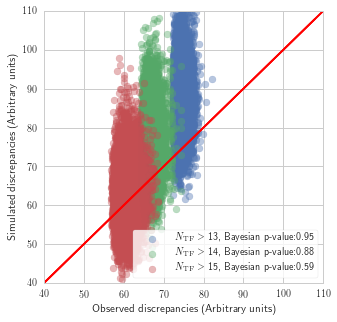

In [22]:
# Here we sample the posterior for the linear model and do the model check with the discrepancy function
# We increase the lower limiting number of measurements per galaxy in each model run
plt.figure(figsize=(5,5))
nh=13 # lowest initial limiting number of measurements
for i in range(nh,nh+3): # run the posterior sampler/model check for three lowest limiting number of measurements
    filt=np.array(em)>i
    print("Galaxies in sample: ",filt.sum()," for N_meas > ",i)
    x=np.array(dboot)[filt] # median bootstrap distance
    y=np.array(bootp50)[filt] # H distance error
    nll = lambda *args: -lnlike2(*args) # likelihood as lambda function for ML estimation
    result = op.minimize(nll, [1.]*3, args=(x, y)) # ML estimation for m,b,f
    m_ml, b_ml,f_ml = result["x"]
    print("ML estimation: ",m_ml,b_ml,f_ml)
    ndim, nwalkers = len(result["x"]), 100 # set up the number of MCMC random walkers
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] # set up initial positions of MCMC RW
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) # set up the MCMC sampler
    steps=10000 # let the walkers walk 10000 steps (1000 will do the trick as well)
    sampler.run_mcmc(pos, steps); # run the sampler
    # Here we remove the burn-in steps, which we estimate to be below 100
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0) # mean MCMC estimation for m,b,f: should not be too different from ML estimation
    print("MCMC estimation: ",sth)
    discrep2(i,samples,x,y) # run model check function
                            # yields discrepancy plot, rejection rate, and Bayesian "p-value"
plt.legend(loc='lower right',frameon=True)
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(40,110)
plt.ylim(40,110)
# store sampler results for prediction below
sth1=sth
samples1=samples
x1=x
y1=y
nhmax=nh+2

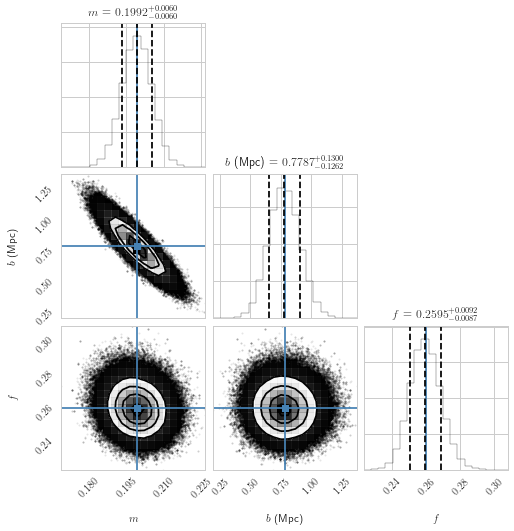

In [23]:
# corner plot for the posterior samples of the "best" model above (for H errors)
fig = corner.corner(samples, labels=["$m$", "$b$ (Mpc)","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

(0, 35)

<Figure size 360x360 with 0 Axes>

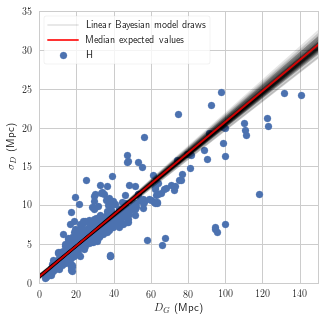

In [24]:
# Draws from the "best" model plotted along the H errors used in the model
# Projection of emcee results into the space of the observed data
plt.figure(figsize=(5,5))
xl = np.linspace(0,160,2)
sth=np.median(samples,axis=0)
plt.figure(figsize=(5,5))
for m, b,f in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear Bayesian model draws")
plt.scatter(x,y,label='H')
plt.plot(xl, sth[0]*xl+sth[1], color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,35)

Text(0,0.5,'H Error (Mpc)')

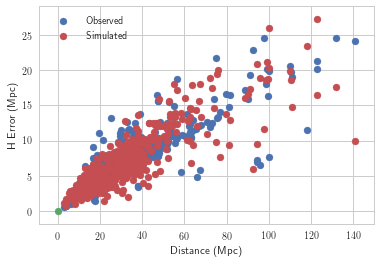

In [25]:
# Plot a set of ysim (synthetic errors produced by the model) along with the observed y (errors)
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y,label="Observed")
plt.scatter([0],[0])
plt.scatter(x,ysim,label="Simulated")
plt.legend()
plt.xlabel("Distance (Mpc)")
plt.ylabel("H Error (Mpc)")

Autocorrelation time for m,b,f
Mean:  39.9302278416 Stdev:  9.73784951739
Mean:  39.7246276349 Stdev:  11.362319382
Mean:  38.8255617636 Stdev:  9.56728840357


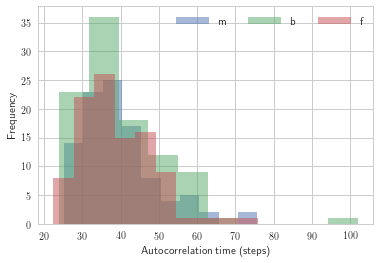

In [26]:
# Estimate autocorrelation time of the MCMC sampling for the "best" model
print("Autocorrelation time for m,b,f")
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)
    print("Mean: ",autocorr.mean(),"Stdev: ",autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

## Linear model for M errors

The ideal model should yield that the discrepancy points are evenly distributed above and below the obs=sim line. This is also reflected in a Bayesian "p-value" close(-ish) to 0.5

Galaxies in sample:  1180  for N_meas >  11
ML estimation:  0.138951215996 0.601548300923 0.219277552129
MCMC estimation:  [ 0.1389433   0.60212932  0.21967348]
Rejection rate = 0 %
Bayesian p-value: 0.997266099635
Galaxies in sample:  926  for N_meas >  12
ML estimation:  0.141318289813 0.540071476554 0.228716029361
MCMC estimation:  [ 0.14130194  0.54093335  0.2292377 ]
Rejection rate = 0 %
Bayesian p-value: 0.947774842512
Galaxies in sample:  732  for N_meas >  13
ML estimation:  0.141415263308 0.522741632541 0.2311582309
MCMC estimation:  [ 0.14137862  0.52443789  0.23183481]
Rejection rate = 0 %
Bayesian p-value: 0.608434348579


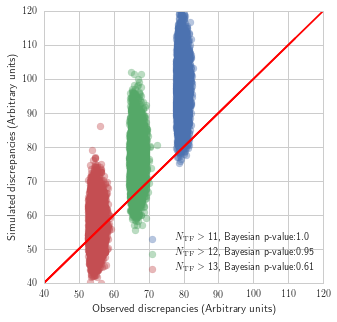

In [27]:
# Here we sample the posterior for the linear model and do the model check with the discrepancy function
# We increase the lower limiting number of measurements per galaxy in each model run
plt.figure(figsize=(5,5))
nm=11 # lowest initial limiting number of measurements
for i in range(nm,nm+3): # run the posterior sampler/model check for three lowest limiting number of measurements
    filt=np.array(em)>i
    print("Galaxies in sample: ",filt.sum()," for N_meas > ",i)
    x=np.array(dboot)[filt] # median bootstrap distance
    y=np.array(bootmad)[filt] # M distance error
    nll = lambda *args: -lnlike2(*args) # likelihood as lambda function for ML estimation
    result = op.minimize(nll, [1.]*3, args=(x, y)) # ML estimation for m,b,f
    m_ml, b_ml,f_ml = result["x"]
    print("ML estimation: ",m_ml,b_ml,f_ml)
    ndim, nwalkers = len(result["x"]), 100 # set up the number of MCMC random walkers
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] # set up initial positions of MCMC RW
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y)) # set up the MCMC sampler
    steps=10000 # let the walkers walk 10000 steps (1000 will do the trick as well)
    sampler.run_mcmc(pos, steps); # run the sampler
    # Here we remove the burn-in steps, which we estimate to be below 100
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    sth=samples.mean(axis=0) # mean MCMC estimation for m,b,f: should not be too different from ML estimation
    print("MCMC estimation: ",sth)
    discrep2(i,samples,x,y) # run model check function
                            # yields discrepancy plot, rejection rate, and Bayesian "p-value"
plt.legend(loc='lower right')
plt.xlabel('Observed discrepancies (Arbitrary units)')
plt.ylabel('Simulated discrepancies (Arbitrary units)')
plt.xlim(40,120)
plt.ylim(40,120)
# store sampler results for prediction below
sth2=sth
samples2=samples
x2=x
y2=y
nmmax=nm+2

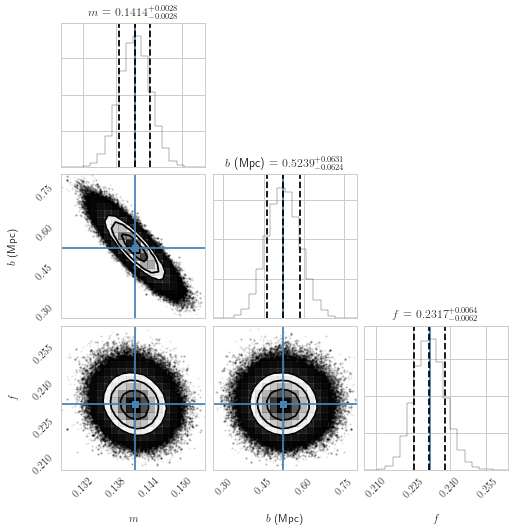

In [28]:
# corner plot for the posterior samples of the "best" model above (for M errors)
fig = corner.corner(samples, labels=["$m$", "$b$ (Mpc)","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')

(0, 25)

<Figure size 360x360 with 0 Axes>

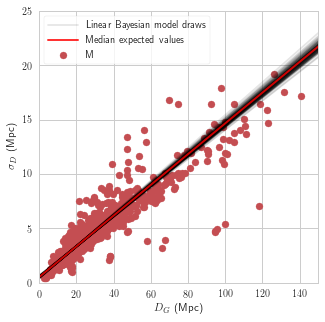

In [29]:
# Draws from the "best" model plotted along the M errors used in the model
# Projection of emcee results into the space of the observed data
plt.figure(figsize=(5,5))
xl = np.linspace(0,160,2)
sth=np.median(samples,axis=0)
plt.figure(figsize=(5,5))
for m, b,f in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m*xl+b, color="k", alpha=0.1,label="Linear Bayesian model draws")
plt.scatter(x,y,c=current_palette[2],label='M')
plt.plot(xl, sth[0]*xl+sth[1], color="r", lw=2, alpha=0.8,label="Median expected values")
plt.legend(frameon=True)
plt.xlabel(r"$D_G$ (Mpc)")
plt.ylabel(r'$\sigma_D$ (Mpc)')
plt.xlim(0,150)
plt.ylim(0,25)

Text(0,0.5,'M Error (Mpc)')

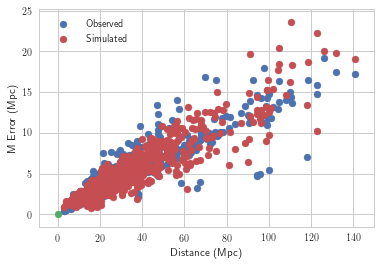

In [30]:
# Plot a set of ysim (synthetic errors produced by the model) along with the observed y (errors)
modpar=samples[np.random.randint(len(samples))]
ysim=np.random.normal(modpar[0]*x+modpar[1],modpar[2]*(modpar[0]*x+modpar[1]))
plt.scatter(x,y,label="Observed")
plt.scatter([0],[0])
plt.scatter(x,ysim,label="Simulated")
plt.legend()
plt.xlabel("Distance (Mpc)")
plt.ylabel("M Error (Mpc)")

Autocorrelation time for m,b,f
Mean:  39.1543119054 Stdev:  9.17336504955
Mean:  38.9942561429 Stdev:  9.83431034104
Mean:  38.8577975045 Stdev:  9.49645339358


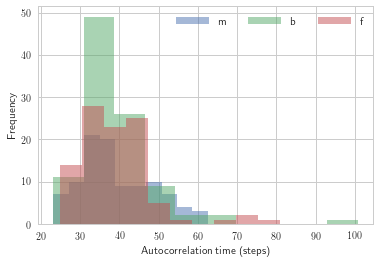

In [31]:
# Estimate autocorrelation time of the MCMC sampling for the "best" model
print("Autocorrelation time for m,b,f")
for j in range(3):
    autocorr=[]
    for i in range(100):
        autocorr.append(emcee.autocorr.integrated_time(sampler.chain[i,:,j],c=5))
    autocorr=np.asarray(autocorr)
    plt.hist(autocorr,alpha=0.5)
    print("Mean: ",autocorr.mean(),"Stdev: ",autocorr.std())
plt.xlabel("Autocorrelation time (steps)")
plt.ylabel("Frequency")
plt.legend(
           ['m','b','f'],
           scatterpoints=1,
           loc='upper right',
           ncol=4,
           fontsize=11)

In [32]:
# Not required: run if you want to save the posterior samples locally (Warning: 70+MB files)
# These posterior samples are also available online from the github repository at:
# https://github.com/saint-germain/anisotropias/raw/master/posterior_lm.txt
# https://github.com/saint-germain/anisotropias/raw/master/posterior_lh.txt
np.savetxt('posterior_lh.txt',samples1)
np.savetxt('posterior_lm.txt',samples2)

In [33]:
nhmax # keep these limits in mind for the next notebook (prediction_errors)

15

In [34]:
nmmax

13

Text(0,0.5,'$\\sigma_\\sigma$ (Mpc)')

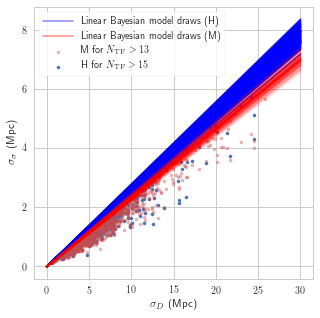

In [35]:
# this plot shows agreement between the bayesian linear model predictions for the variance in H/M errors 
# and the bootstrap variance in H/M errors
plt.figure(figsize=(5,5))
di=np.linspace(0,30,2)
for m, b,f in samples1[np.random.randint(len(samples1), size=100)]:
    plt.plot(di, f*di, zorder=1, color="b", alpha=0.8)
plt.plot(di, f*di,color="b", alpha=0.4,label="Linear Bayesian model draws (H)")
for m, b,f in samples2[np.random.randint(len(samples2), size=100)]:
    plt.plot(di, f*di, color="r", alpha=0.1)
plt.plot(di, f*di, color="r", alpha=0.4,label="Linear Bayesian model draws (M)")
filt=np.array(em)>nmmax
y=np.array(bootp50)[filt]
ms=np.array(bootmsig)[filt]
plt.scatter(y,ms,s=10,c=current_palette[2],alpha=0.4,label='M for $N_\mathrm{TF}>13$',zorder=2)
filt=np.array(em)>nhmax
y=np.array(bootp50)[filt]
ee=np.array(bootsig)[filt]
plt.scatter(y,ee,s=10,c=current_palette[0],alpha=1,label='H for $N_\mathrm{TF}>15$',zorder=1)
plt.legend(frameon=True)
plt.xlabel(r"$\sigma_D$ (Mpc)")
plt.ylabel(r'$\sigma_\sigma$ (Mpc)')

In [36]:
ndf.meas[ndf.meas>nmmax].sum() # total measurements in M linear model / M quadratic model

13054

In [37]:
ndf.meas[ndf.meas>nhmax].sum() # total measurements in H linear model

9361

In [38]:
ndf.meas[ndf.meas>25].sum() # total measurements in H quadratic model

866